library needed 

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D,MaxPooling2D,concatenate,UpSampling2D,Dropout,Input
from tensorflow.keras.metrics import Precision,Recall
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Accuracy,Precision , Recall
from sklearn.model_selection import train_test_split
import numpy as np 
import matplotlib.pyplot as plt

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Unet like architecture proposed

In [2]:
def Unet(input_size):
    """encoder"""
    #block 1 
    input_scan = Input(input_size)
    x  = Conv2D(32,(3,3),padding="same",activation= 'relu')(input_scan)
   
    a_1 = tf.keras.layers.ReLU()(x)
    #block 2
    x_1 =MaxPooling2D((2,2),strides=2)(a_1)
    x_1  = Conv2D(64,(3,3),padding="same",activation= 'relu')(x_1)

    a_2 =tf.keras.layers.ReLU()(x_1)
    #block 3
    x_2 =MaxPooling2D((2,2),strides=2)(a_2)
    x_2  = Conv2D(128,(3,3),padding="same",activation= 'relu')(x_2)
   
    a_3 = tf.keras.layers.ReLU()(x_2)
    #block 4
    x_3 =MaxPooling2D((2,2),strides=2)(a_3)
    x_3  = Conv2D(256,(3,3),padding="same",activation= 'relu')(x_3)
   
    a_4 = tf.keras.layers.ReLU()(x_3)
    #block 5
    x_4 =MaxPooling2D((2,2),strides=2)(a_4)
    x_4  = Conv2D(512,(3,3),padding="same",activation= 'relu')(x_4)
   
    
    """decoder"""
    #block 1
    x_4 =UpSampling2D((2,2))(x_4)
    c_1 =  concatenate([x_3,x_4])
    d  = Conv2D(256,(3,3),padding="same",activation= 'relu')(c_1)
  
    #block 2
    d =UpSampling2D((2,2))(d)
    c_1 =  concatenate([d,x_2])
    d  = Conv2D(128,(3,3),padding="same",activation= 'relu')(c_1)
    
    #block 3
    d =UpSampling2D((2,2))(d)
    c_1 =  concatenate([x_1,d])
    d  = Conv2D(64,(3,3),padding="same",activation= 'relu')(c_1)
    
    #block 4
    d =UpSampling2D((2,2))(d)
    c_1 =  concatenate([d,x])
    d  = Conv2D(32,(3,3),padding="same",activation= 'relu')(c_1)
    
    d = Dropout(0.30)(d)
    out_put = Conv2D(1,1,padding ='same',activation= 'sigmoid')(d)
    model = tf.keras.Model(input_scan,out_put,name='U_net')
    return model

In [3]:
model = Unet((512,512,1))

In [4]:
model.summary()

Model: "U_net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 32  320         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 re_lu (ReLU)                   (None, 512, 512, 32  0           ['conv2d[0][0]']                 
                                )                                                             

In [5]:
X = np.load("/kaggle/input/data12/X1.npy")
Y = np.load("/kaggle/input/data12/mask.npy")

In [6]:
X = X/255

In [7]:
Xtrain,Xtest,Ytrain,Ytest = train_test_split(X,Y,test_size =0.1,random_state=48)

In [8]:
model.compile(optimizer = Adam(learning_rate=0.0001),loss = "BinaryCrossentropy",metrics=["accuracy"])

In [9]:
hist = model.fit(Xtrain,Ytrain,epochs=50,batch_size=16,validation_data=(Xtest,Ytest))

Epoch 1/50


2023-05-06 10:05:55.395287: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inU_net/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


67/67 [==============================] - 57s 630ms/step - loss: 0.1447 - accuracy: 0.9574 - val_loss: 0.0165 - val_accuracy: 0.9994
Epoch 2/50
67/67 [==============================] - 33s 499ms/step - loss: 0.0118 - accuracy: 0.9994 - val_loss: 0.0092 - val_accuracy: 0.9994
Epoch 3/50
67/67 [==============================] - 33s 499ms/step - loss: 0.0071 - accuracy: 0.9995 - val_loss: 0.0061 - val_accuracy: 0.9994
Epoch 4/50
67/67 [==============================] - 34s 505ms/step - loss: 0.0054 - accuracy: 0.9995 - val_loss: 0.0050 - val_accuracy: 0.9994
Epoch 5/50
67/67 [==============================] - 34s 505ms/step - loss: 0.0049 - accuracy: 0.9995 - val_loss: 0.0050 - val_accuracy: 0.9994
Epoch 6/50
67/67 [==============================] - 33s 499ms/step - loss: 0.0044 - accuracy: 0.9995 - val_loss: 0.0045 - val_accuracy: 0.9994
Epoch 7/50
67/67 [==============================] - 33s 499ms/step - loss: 0.0040 - accuracy: 0.9995 - val_loss: 0.0039 - val_accuracy: 0.9994
Epoch 8/50

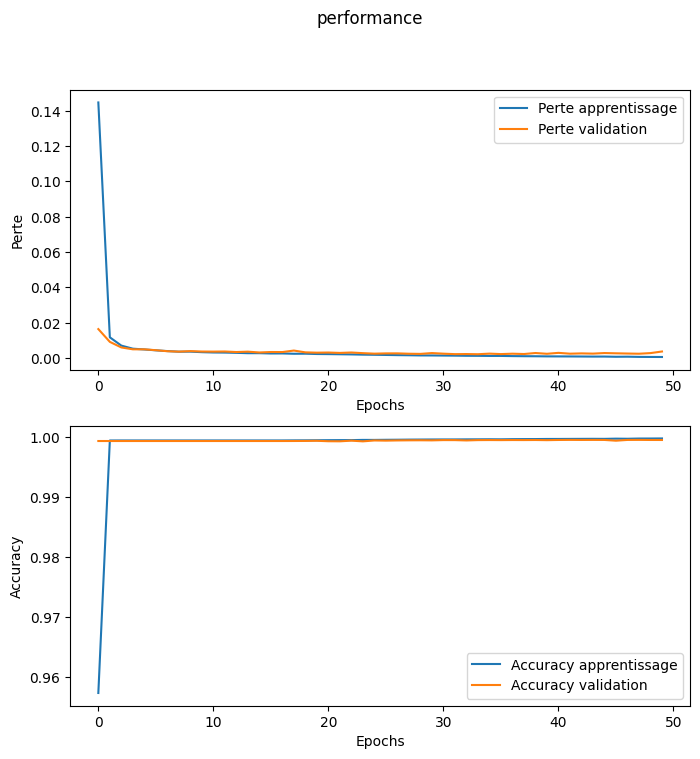

In [42]:
plt.figure(1, figsize=(8, 8))
plt.suptitle("performance") 
plt.subplot(2, 1, 1)
plt.plot(np.arange(0, 50), hist.history["loss"], label="Perte apprentissage")
plt.plot(np.arange(0, 50), hist.history["val_loss"], label="Perte validation")
plt.xlabel("Epochs")
plt.ylabel("Perte")
plt.legend() 
plt.subplot(2, 1, 2)
plt.plot(np.arange(0, 50), hist.history["accuracy"], label="Accuracy apprentissage")
plt.plot(np.arange(0, 50), hist.history["val_accuracy"], label="Accuracy validation") 
plt.xlabel("Epochs") 
plt.ylabel("Accuracy")
plt.legend()

plt.legend()


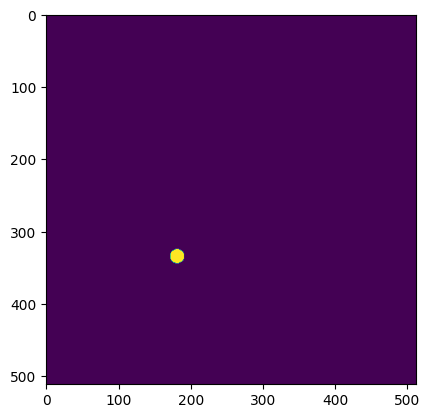

In [11]:
plt.imshow(Ytest[5])

In [12]:
#X = np.load("/kaggle/input/data12/X0.npy")
#X = X/255
y_1 = model.predict(Xtest[5].reshape((1,512,512, 1)))

1/1 [==============================] - 1s 626ms/step


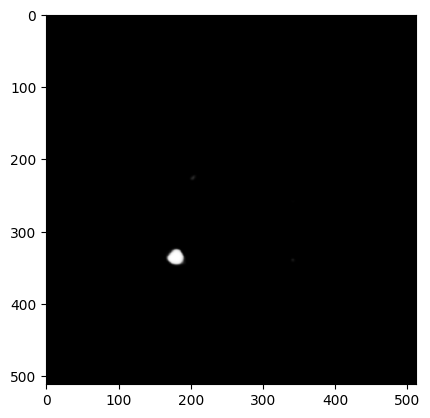

In [13]:
y_1 = y_1.reshape((512,512))
plt.imshow(y_1,cmap="gray")

In [14]:
y_1.max()

0.9467039

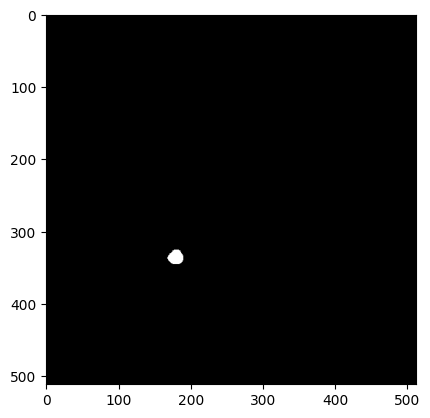

In [15]:
y_1 = np.where(y_1>0.5,1,0)
plt.imshow(y_1,cmap="gray")

In [16]:

norm_img = Xtest[5].reshape((512,512))
img = norm_img * 255

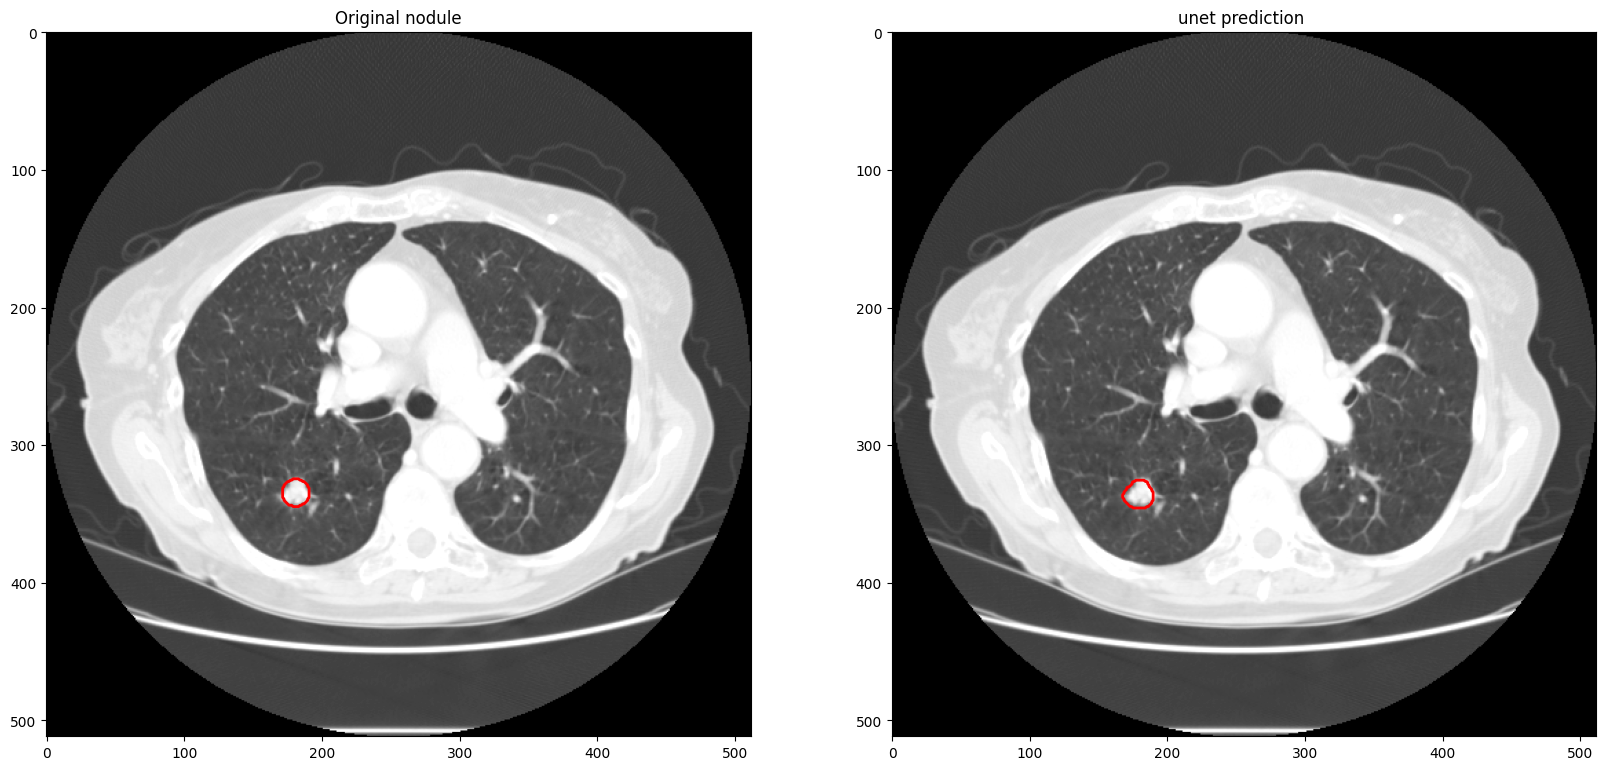

In [17]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 20))
ax1.imshow(img,cmap="gray" )
ax1.set_title('Original nodule')
ax2.imshow(img,cmap='gray')
ax2.set_title('unet prediction ')
ax2.contour(y_1.reshape((512,512)), levels=[0.4], colors='r', linewidths=2)
ax1.contour(Ytest[5].reshape((512,512)), levels=[0.4], colors='r', linewidths=2)
plt.show()

In [38]:
import skimage.io
import skimage.measure
import numpy as np

# Load the mask image
mask = y_1

# Find the center and diameter of the circle
label_mask = skimage.measure.label(mask)
props = skimage.measure.regionprops(label_mask)
circle_props = max(props, key=lambda x: x.area)
center = circle_props.centroid
diameter = circle_props.equivalent_diameter

# Print the results
print('Center:', center)
print('Diameter:', diameter)

Center: (336.06231454005933, 179.16023738872403)
Diameter: 20.71428798138497


In [39]:
import skimage.io
import skimage.measure
import numpy as np

# Load the mask image
mask = Ytest[5].reshape((512,512))

# Find the center and diameter of the circle
label_mask = skimage.measure.label(mask)
props = skimage.measure.regionprops(label_mask)
circle_props = max(props, key=lambda x: x.area)
center = circle_props.centroid
diameter = circle_props.equivalent_diameter

# Print the results
print('Center:', center)
print('Diameter:', diameter)

Center: (334.527868852459, 180.98360655737704)
Diameter: 19.706294962377495
